In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,FastICA,TruncatedSVD
from sklearn.feature_selection import SelectKBest,RFE,f_classif,chi2,mutual_info_classif
import time
from sklearn.metrics import silhouette_score

In [35]:
hp={
    "cov_thresh":0.8,
    'ex_var' : 0.7, # explained variace
    'k':3
}

# Step 1

In [36]:
df = pd.read_csv('iris.csv')

print(df.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [37]:
df = df.drop('Id', axis=1)
print(df.columns)

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [39]:
null_counts = df.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print("columns with null values:", columns_with_nulls)

columns with null values: Series([], dtype: int64)


no null data , no categorical data that require one hot encoding too

In [40]:
df['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [41]:
df['Species'] = df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1,'Iris-virginica':2})

In [42]:
df['Species'].value_counts()

Species
0    50
1    50
2    50
Name: count, dtype: int64

In [43]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


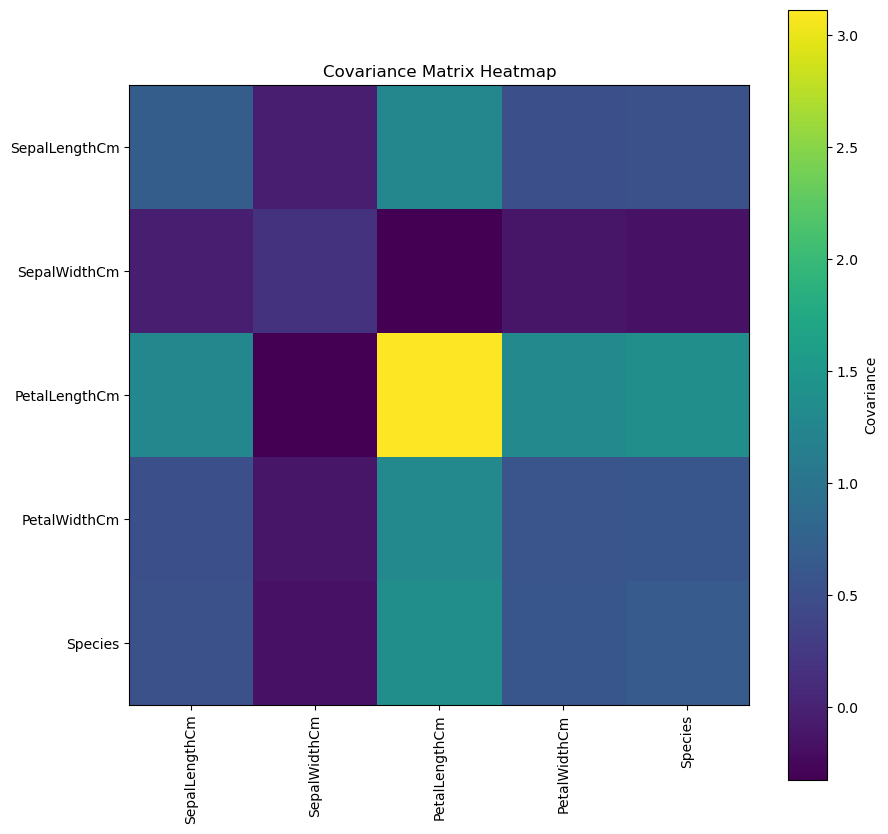

In [44]:
cov_matrix = df.cov()

plt.figure(figsize=(10, 10))
plt.imshow(cov_matrix)
plt.colorbar(label='Covariance')
plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns,rotation=90)
plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
plt.title('Covariance Matrix Heatmap')
plt.show()

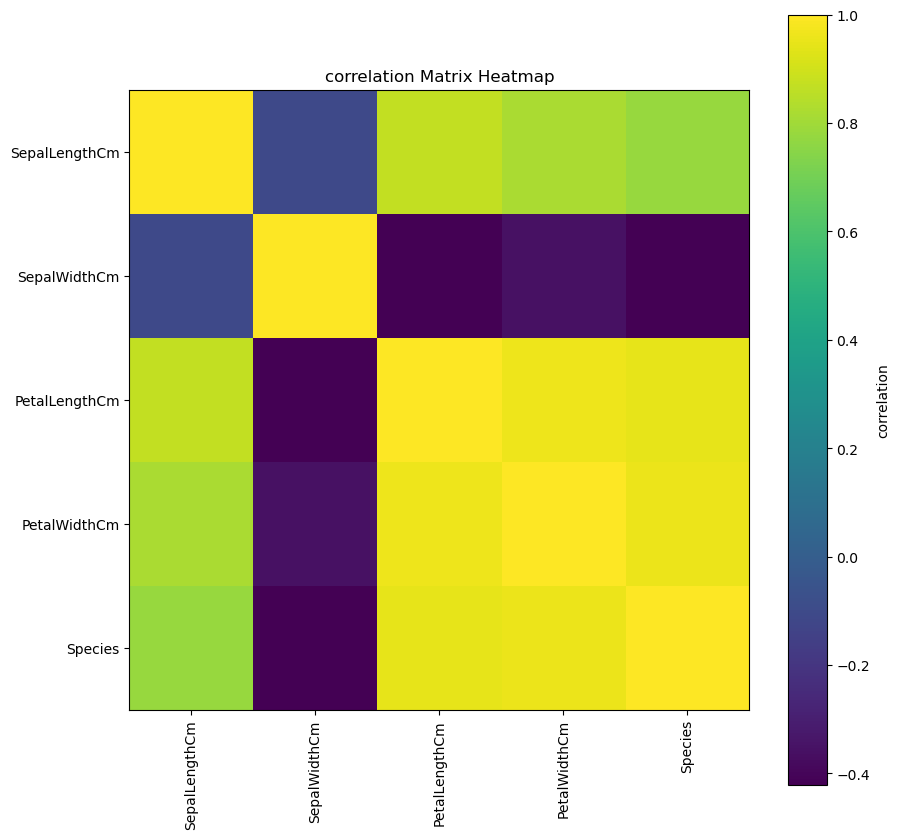

In [45]:
corr_matrix = df.corr() # pandas automaticly standardize

plt.figure(figsize=(10, 10))
plt.imshow(corr_matrix)
plt.colorbar(label='correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns,rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('correlation Matrix Heatmap')
plt.show()

In [46]:
print(f"Feature with strong correlation (> {hp["cov_thresh"]} or < {-hp["cov_thresh"]}):\n")
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # avoid duplicates and self correlation (upper triangle)
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > hp["cov_thresh"]:
            print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {corr_value}")

Feature with strong correlation (> 0.8 or < -0.8):

SepalLengthCm - PetalLengthCm: 0.8717541573048716
SepalLengthCm - PetalWidthCm: 0.8179536333691642
PetalLengthCm - PetalWidthCm: 0.9627570970509662
PetalLengthCm - Species: 0.9490425448523334
PetalWidthCm - Species: 0.9564638238016178


In [47]:
X = df.iloc[:, :-1]   # all columns except last
y = df.iloc[:, -1]    # only last column


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, # dataset is small so i use 0.8       
#     random_state=42,     
#     shuffle=True         
# )

# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)

In [48]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# normal data

In [49]:
kmeans = KMeans(n_clusters=hp["k"], random_state=42) # lloyd
kmeans.fit(X)

# inertia (sum of squared distances of samples to their closest cluster center)
print(f"Inertia: {kmeans.inertia_:.3f}")
print(f"Silhouette Score: {silhouette_score(X, kmeans.labels_):.3f}")

Inertia: 78.945
Silhouette Score: 0.551


c:\Users\alias\anaconda3\envs\workshop\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [50]:
kmeans = KMeans(n_clusters=hp["k"], random_state=42) # lloyd
start_time = time.time()
kmeans.fit(X_scaled)
end_time = time.time()
print(f"time : {end_time-start_time:.4f}")
# inertia (sum of squared distances of samples to their closest cluster center)
print(f"Inertia: {kmeans.inertia_:.3f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans.labels_):.3f}")

time : 0.0046
Inertia: 192.037
Silhouette Score: 0.479


c:\Users\alias\anaconda3\envs\workshop\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# PCA

In [51]:
pca = PCA(n_components=hp["ex_var"],random_state=42)  # Choose enough components to explain 50% variance
X_pca = pca.fit_transform(X_scaled)

print("number of components selected:", pca.n_components_)
print("explained variance ratio of selected components:", pca.explained_variance_ratio_)
print("total explained variance:", sum(pca.explained_variance_ratio_))

number of components selected: 1
explained variance ratio of selected components: [0.72770452]
total explained variance: 0.7277045209380135


In [52]:
kmeans = KMeans(n_clusters=hp["k"], random_state=42) # lloyd
start_time = time.time()
kmeans.fit(X_pca)
end_time = time.time()
print(f"time : {end_time-start_time:.4f}")
# inertia (sum of squared distances of samples to their closest cluster center)
print(f"Inertia: {kmeans.inertia_:.3f}")
print(f"Silhouette Score: {silhouette_score(X_pca, kmeans.labels_):.3f}")

time : 0.0061
Inertia: 23.468
Silhouette Score: 0.677


c:\Users\alias\anaconda3\envs\workshop\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# svd

In [53]:
for i in range(1,X.shape[1]+1,1):
    svd = TruncatedSVD(n_components=i,random_state=42)
    svd.fit(X_scaled)
    if(sum(svd.explained_variance_ratio_)>=hp["ex_var"]):
        break

X_svd = svd.transform(X_scaled)
print("number of components selected:", i)
print("explained variance ratio of selected components:", svd.explained_variance_ratio_)
print("total explained variance:", sum(svd.explained_variance_ratio_))

number of components selected: 1
explained variance ratio of selected components: [0.72770452]
total explained variance: 0.7277045209380136


In [54]:
kmeans = KMeans(n_clusters=hp["k"], random_state=42) # lloyd
start_time = time.time()
kmeans.fit(X_svd)
end_time = time.time()
print(f"time : {end_time-start_time:.4f}")
# inertia (sum of squared distances of samples to their closest cluster center)
print(f"Inertia: {kmeans.inertia_:.3f}")
print(f"Silhouette Score: {silhouette_score(X_svd, kmeans.labels_):.3f}")

time : 0.0068
Inertia: 23.468
Silhouette Score: 0.677


c:\Users\alias\anaconda3\envs\workshop\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# ICA

In [55]:
ica = FastICA(n_components=int(X.shape[1]/2),random_state=42)  # choose n comp as half of the features
X_ica = ica.fit_transform(X_scaled)

print("number of components selected:", int(X.shape[1]/2))

number of components selected: 2


In [56]:
kmeans = KMeans(n_clusters=hp["k"], random_state=42) # lloyd
start_time = time.time()
kmeans.fit(X_ica)
end_time = time.time()
print(f"time : {end_time-start_time:.4f}")
# inertia (sum of squared distances of samples to their closest cluster center)
print(f"Inertia: {kmeans.inertia_:.3f}")
print(f"Silhouette Score: {silhouette_score(X_ica, kmeans.labels_):.3f}")

time : 0.0054
Inertia: 95.090
Silhouette Score: 0.477


c:\Users\alias\anaconda3\envs\workshop\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
